[486, 486]


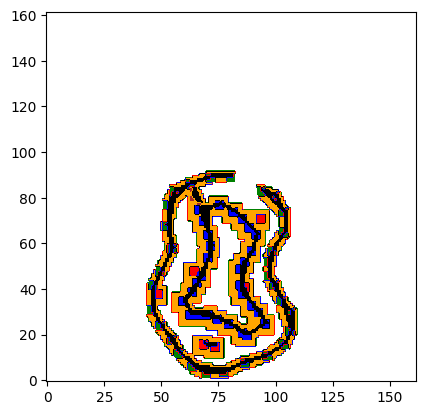

[[[85, 86], [81, 90], 0.0565685424949238, 135.0, 135.0], [[81, 90], [77, 94], 0.0565685424949238, 0.0, 135.0], [[77, 94], [67, 99], 0.1118033988749895, 18.434948822921996, 153.434948822922], [[67, 99], [60, 97], 0.07280109889280519, 42.51044707800088, -164.05460409907712], [[60, 97], [53, 95], 0.07280109889280519, 0.0, -164.05460409907712], [[53, 95], [48, 92], 0.05830951894845301, 15.018360631150642, -149.03624346792648], [[48, 92], [40, 92], 0.08, -30.96375653207349, 180.00000000000003], [[40, 92], [36, 96], 0.0565685424949238, -45.00000000000003, 135.0], [[36, 96], [31, 99], 0.05830951894845301, 14.036243467926482, 149.03624346792648], [[31, 99], [21, 101], 0.1019803902718557, 19.653824058053317, 168.6900675259798], [[21, 101], [19, 96], 0.053851648071345036, 79.50852298766836, -111.80140948635184], [[19, 96], [15, 92], 0.0565685424949238, -23.198590513648156, -135.0], [[15, 92], [15, 84], 0.08, 45.0, -90.0], [[15, 84], [18, 80], 0.05, 36.86989764584402, -53.13010235415598], [[18, 8

KeyboardInterrupt: 

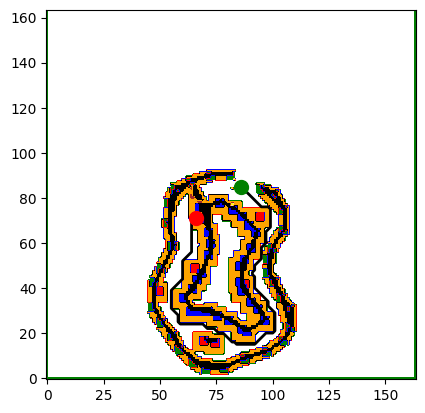

In [1]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt
import ev3_dc as ev3
from matplotlib import colors

trajectory = []
path = []

class Main():
    def __init__(self) -> None:
        global trajectory
        global path
        self.grid_size = 3
        landmarks = np.loadtxt("landmarks.csv", delimiter=",")

        size_x = int((max(np.abs(landmarks[:,0])))+10)
        size_y = int((max(np.abs(landmarks[:,1])))+10)
        world_coords=[max(size_x, size_y)*2, max(size_x, size_y)*2]
        print(world_coords)
        discretizer = Discretizer(landmarks, grid_size=self.grid_size, world_coords=world_coords)
        discretizer.createMap(surrounding=6)
        
        cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink', "yellow"])
        plt.figure('Shortest path')
        plt.imshow( discretizer.world_map.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=8)
        plt.show()


        middle_point = np.array([int(world_coords[0]/2), int(world_coords[1]/2)])
        start = [84, 85]
        end = [70,65]
        
        a_star = A_Star(start, end, start, discretizer.world_map.transpose(1,0))
        path = a_star.find_path()
        d=a_star.d[1:world_coords[0]+1,1:world_coords[1]+1]
        # trajectory = a_star.plan_trajectory(12)
        trajectory = a_star.plan_trajectory()
        initial_trajectory = trajectory
        print(trajectory)
        print(len(trajectory))

        # plot shortest path
        #  0 = background / 1,2,3 = Markers / 4 = border / 5 = padding / 6 = start/finish / discs = 7 /
        cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink', 'yellow'])
        plt.figure('Shortest path')
        plt.imshow(a_star.world_map + discretizer.mask.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=8)
        plt.plot(path[1],path[0], color="black", lw=2, label = 'A-Star')
        plt.plot(a_star.start[1]+1,a_star.start[0]+1,'g.',markersize=20)
        plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)

        # i = 0
        # check = False
        # while True:
        #     if len(trajectory) > 0:
        #         # if (i%5 == 0) and (i > 0):
        #         #     print("Calc new trajectory")
        #         #     current_pos = [current_pos[0], current_pos[1]+1]
        #         #     print("Start:", current_pos)
        #         #     if i+4 < len(initial_trajectory):
        #         #         new_end = [initial_trajectory[i+4][1][0], initial_trajectory[i+4][1][1]]
        #         #     else:
        #         #         new_end = [initial_trajectory[-1][1][0], initial_trajectory[-1][1][1]]
        #         #     print("End: ", new_end)
        #         #     plt.plot(new_end[1]+1,new_end[0]+1,'r.',markersize=20, alpha=.8)

        #         #     a_star = A_Star(current_pos, new_end, start, discretizer.world_map.transpose(1,0))
        #         #     path = a_star.find_path()
        #         #     new_trajectory = a_star.plan_trajectory()[:-1]
        #         #     plt.plot(current_pos[1]+1,current_pos[0]+1,'y.',markersize=20, alpha=.8)
        #         #     check = not(check)
                
        #         #     if i+4 < len(initial_trajectory):
        #         #         trajectory = new_trajectory + initial_trajectory[i+4]
        #         #     else:
        #         #         trajectory = new_trajectory + initial_trajectory[-1]
        #         #     i += 1
        #         #     continue

        #         move = trajectory.pop(0)
        #         print(move)
                
        #         if not check:
        #             plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="red", lw=2)
        #             current_pos = [move[1][0], move[1][1]]
        #         else:
        #             plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="blue", lw=2)
        #             current_pos = [move[1][0], move[1][1]]
        #         i += 1
        #     else:
        #         break
            
        # plt.legend()
        # plt.show()

        self.drivePath(initial_trajectory)

    def drivePath(self, trajectory):
        driving_speed = 35
        turning_speed = 20
        try:
            vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 
            print("Start driving!")
            print(trajectory)
            trajectory[0][3] = trajectory[0][3] - 90
            last_move = 0
            for move in trajectory:
                if -move[3] < 15 and -move[3] > -15:
                    print(f"turn with {-move[3]} => Too small")
                    last_move += -move[3]
                else:
                    print(f"turn with {-move[3] + last_move}")
                    vehicle.drive_turn(-move[3] + last_move, 0.0, speed=turning_speed).start(thread=False)
                    last_move = 0
                print(f"drive straight for {move[2]* self.grid_size}cm")
                vehicle.drive_straight(move[2] * self.grid_size, speed=driving_speed, brake=True).start(thread=False)

        except Exception as e:
                    print(e)
        vehicle.stop()
	
if __name__ == '__main__':
    main = Main()


In [8]:
import numpy as np
test = np.array([[3,4,5,6],[1,2,3,4],[3,2,4,2]])
test = test[test[:,0]==3]
np.mean(test[:,1])

3.0

In [3]:
import numpy as np
test = np.array([1,2,3,4,5])
test2 = np.array([6,7,8,9,19])
test2 = test2[test>2]
test = test[test>2]
print(test)
print(test2)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 3

In [2]:
def drive_track(vehicle,landmarks):
    print('drive_track')
    grid_size = 2
    size_x = int((max(landmarks[:,0])-min(landmarks[:,0]))+10)
    size_y = int((max(landmarks[:,1])-min(landmarks[:,1]))+10)
    world_coords=[max(size_x, size_y)*2, max(size_x, size_y)*2]
    print('world coords')
    print(world_coords)
    discretizer = Discretizer(landmarks, grid_size=grid_size, world_coords=world_coords)
    print('created')
    discretizer.createMap(surrounding=6)
    print('discretized')
    middle_point = np.array([int(world_coords[0]/2), int(world_coords[1]/2)])
    start = np.array([1,1]) + ((np.array([0,27]) + middle_point)/grid_size).astype(int)
    end = np.array([1,1]) + ((np.array([0,70]) + middle_point)/grid_size).astype(int)
    print(start)
    print(end)
    a_star = A_Star(list(start), list(end), discretizer.world_map.transpose(1,0))
    path = a_star.find_path()
    print('path created')
    trajectory = a_star.plan_trajectory(3)

    print('starting plot')
    cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink'])
    plt.figure('Shortest path')
    plt.imshow(a_star.world_map + discretizer.mask.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=7)
    plt.plot(path[1],path[0], color="black", lw=2)
    plt.plot(a_star.start[1]+1,a_star.start[0]+1,'g.',markersize=20)
    plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)

    print('saving')
    plt.savefig('initial_map.png')

    for move in trajectory:
        plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="red", lw=2)

    plt.show()
    print(trajectory)

landmarks = np.loadtxt("landmarks.csv", delimiter=",")
drive_track(None, landmarks)

drive_track
world coords
[224, 224]
created
discretized
[57 70]
[57 92]
path created


TypeError: plan_trajectory() takes 1 positional argument but 2 were given

In [7]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt
import ev3_dc as ev3
from matplotlib import colors

world_coords=[300,300]
landmarks = np.loadtxt("landmarks.csv", delimiter=",")
discretizer = Discretizer(landmarks, world_coords=world_coords)
discretizer.createMap(surrounding=12)
bin_map = np.where(discretizer.world_map >= 1, 1,0)
np.unique(bin_map)

array([0, 1])

In [2]:
import numpy as np
print(np.degrees(2.58))
print(np.degrees(-5.11))
print(np.degrees(0.93))
print(np.degrees(0.24))

147.82311114375239
-292.78143331185066
53.285074947166564
13.750987083139757


In [1]:
trajectory = [[[87, 100], [86, 110], 0.1004987562112089, 1.6704649792860586], 
            [[86, 110], [86, 121], 0.11, -0.09966865249116208]]

In [2]:
import ev3_dc as ev3
import numpy as np

try:
    vehicle = ev3.TwoWheelVehicle (
        0.02968,
        0.12832, 
        protocol=ev3.USB
    ) 
    print("Start driving!")
    speed = 20
    trajectory[0][3] =  trajectory[0][3] - (np.pi/2)
    for move in trajectory:
        if np.degrees(move[3]) > 1 or np.degrees(move[3]) < -1 :
            print(f"turn with {-(np.degrees(move[3]))} degrees")
            vehicle.drive_turn(-(np.degrees(move[3])), 0.0).start(thread=False)
        if move[2]>0.01:
            print(f"drive straight for {move[2]}cm")
            vehicle.drive_straight(move[2] * 2, speed=speed).start(thread=False)

except Exception as e:
    print(e)

vehicle.stop()


Start driving!
turn with 84.28940686250036 degrees
drive straight for 0.1004987562112089cm
turn with 5.710593137499646 degrees
drive straight for 0.11cm


In [4]:
import ev3_dc as ev3
import numpy as np

with ev3.TwoWheelVehicle(
    0.02775, # 0.02968,  # radius_wheel_measured
    0.13047,   # tread
    protocol=ev3.USB,
) as my_vehicle:
    my_vehicle.drive_turn(3600, 0.0).start(thread=False)

[[[151, 151], [195, 151], 0.44, 0.01],
 [[195, 151], [229, 162], 0.35735136770411274, 0.3029012278803845],
 [[229, 162], [249, 186], 0.31240998703626616, 0.563156822717809],
 [[249, 186], [270, 210], 0.3189043743820395, -0.024091723424921274]]

In [1]:
radius = 0.02705625
tread = 0.12796984462

In [1]:
import ev3_dc as ev3
with ev3.TwoWheelVehicle(
    radius,  # radius_wheel_measured
    tread,  # tread
    protocol=ev3.USB,
) as my_vehicle:
    my_vehicle.drive_straight(2.).start(thread=False)

In [3]:
radius * 1.95 / 2

0.02705625

In [2]:
import ev3_dc as ev3
import numpy as np

with ev3.TwoWheelVehicle(
    radius,  # tread - Floor
    tread,  # radius - Floor 
    protocol=ev3.USB,
) as my_vehicle:
    my_vehicle.drive_turn(-3600, 0.0).start(thread=False)

In [3]:
#tread * (3600 / turned_angle)
tread * (3600 / 3630)

0.12796984462809918

In [1]:
import ev3_dc as ev3
import time
from multiprocessing.pool import ThreadPool
from decimal import Decimal

def driveCorner(vehicle):
    print("START")
    for i in range(10):
        try:
            print("hi")
            vehicle.drive_straight(0.1, speed=20, brake=False).start(thread=False)
            if not vehicle._current_movement is None:
                if 'stopped' in vehicle._current_movement:
                    print("was stopped")
                    break
        except Exception as e:
            print(e)
    vehicle.drive_turn(90, 0.0, brake=True).start(thread=False)
    print("START AGAIN!")
    vehicle.drive_straight(0.2, speed=20, brake=True).start(thread=False)   

def stopper(vehicle):
    time.sleep(3)
    print("STOPPING")
    vehicle.stop()
    del vehicle

vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 

pool = ThreadPool(processes=2)
pool.apply_async(driveCorner, (vehicle,))
pool.apply_async(stopper, (vehicle,))




START
hi


hi
STOPPING
hi
hi
hi
hi
hi


In [1]:
import ev3_dc as ev3
import time
vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 
vehicle.move(speed=10, turn=0).start(thread=True)
time.sleep(2)
vehicle.move(speed=10, turn=90).start(thread=True)


AttributeError: 'NoneType' object has no attribute 'start'

In [1]:
import ev3_dc as ev3
import time
vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 

print(vehicle._current_movement)
vehicle.drive_straight(0.5, speed=20, brake=True).start(thread=False)
current_movement = vehicle._current_movement
time.sleep(1)
print("STOP!")
vehicle.stop()
print(current_movement)
vehicle._current_movement = current_movement
print("TURN")
vehicle.drive_turn(90, 0.0, brake=True).start(thread=False)
print("START AGAIN!")
vehicle.drive_straight(0.2, speed=20, brake=True).start(thread=False)   

None
STOP!
None
TURN
START AGAIN!


In [2]:
import numpy as np
def plan_line(start, end):
    distance = (np.sqrt((start[0] - end[0])**2 + (start[1]-end[1])**2)) * 3/ 100
    angle = np.arctan2(end[1]-start[1], end[0]-start[0])
    hit_obstacle = False
    if np.degrees(angle) < 10:
        angle = 2*np.pi - angle 
    if distance == 0: distance = 0.01
    return distance, angle, hit_obstacle


In [11]:
start = [26, 31] #[31, 26]
end = [46, 37] #[37, 46] 

In [12]:
distance, angle, _ = plan_line(start,end)
print(f'{np.degrees(angle)}, {distance}')

73.30075576600639, 0.626418390534633


In [1]:
import ev3_dc as ev3
import time
from thread_task import Task
from multiprocessing.pool import ThreadPool
from decimal import Decimal
from collections import namedtuple
import numpy as np
free = True
# def driveCorner(vehicle):
#     global free
#     print("S")
#     while True:
#         vehicle.move(10, 0).start(thread=True)
#         print("T")
finish = False
speed_0 = True

def stopper(vehicle):
    global finish
    global free
    travel_for(0.1,vehicle)
    vehicle.drive_turn(90, 0.0, speed=30).start(thread=False)
    travel_for(0.1,vehicle)
    vehicle.drive_turn(90, 0.0, speed=30).start(thread=False)
    finish = True


def travel_for(distance,vehicle):
    try:
        global free
        global speed_0
        speed_0 = False
        free = True
        motor_l_total, motor_r_total = vehicle.motor_pos
        old_angles = [motor_l_total,motor_r_total]
        l_dist_list = []
        r_dist_list = []
        while True:
            l,r,old_angles = get_motor_movement_2(old_angles,vehicle)
            l_dist_list.append(l)
            r_dist_list.append(r)
            distance_traveled = (np.sum(l_dist_list) + np.sum(r_dist_list)) / 2
            if distance_traveled >= distance:
                free = False
                speed_0 = True
                vehicle.stop()
                break
    except Exception as e:
        print(e)

def get_motor_movement_2(old_angles, vehicle):
    try:
        """Read out the movements of the left and right wheels from the motor rotation."""
        motor_l_total, motor_r_total = vehicle.motor_pos
        motor_l = motor_l_total - old_angles[0]
        motor_r = motor_r_total - old_angles[1]
        l = motor_l * np.pi * 0.056 / 360
        r = motor_r * np.pi * 0.056 / 360
        return l, r, [motor_l_total, motor_r_total]
    except Exception as e:
        print(e)




def drive_straight(vehicle):
    global free
    global speed_0
    if free:
        vehicle.move(20,0)
    else:
        pass


vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 

pool = ThreadPool(processes=2)
# pool.apply_async(driveCorner, (vehicle,))
pool.apply_async(stopper, (vehicle,))
while True: 
    if finish:
        break
    pool.apply_async(drive_straight, (vehicle,))




In [3]:
import numpy as np
100 * np.pi * 0.056 / 360

0.048869219055841226

In [ ]:
{'op': 'Step_Speed', 'start_motor_pos': (0, 0), 'speed_left': 20, 'step1_left': 80, 'step2_left': 912, 'step3_left': 40, 'speed_right': 20, 'step1_right': 80, 'step2_right': 912, 'step3_right': 40, 'target_motor_pos': (1032, 1032), 'speed': 20, 'ramp_up': 80, 'ramp_down': 40, 'brake': True, 'last_motor_pos': (436, 435), 'stopped': True}

In [1]:
1+1

2

In [1]:
import ev3_dc as ev3
import time
from multiprocessing.pool import ThreadPool
from decimal import Decimal
from collections import namedtuple

MotorPositions = namedtuple('MotorPositions', [
        'left',
        'right'
])

def driveCorner(vehicle):
    print("START")
    vehicle.drive_straight(1, speed=20, brake=True).start(thread=False)
    vehicle.drive_turn(90, 0.0, brake=True, speed=10).start(thread=False)
    print("START AGAIN!")
    vehicle.drive_straight(0.2, speed=20, brake=True).start(thread=False)   

def stopper(vehicle):
    time.sleep(3)
    print("STOPPING")
    print(vehicle._current_movement)
    vehicle.stop(brake=True)
    print(vehicle._current_movement)
    diff_pos_l = vehicle._current_movement['last_motor_pos'][0] - vehicle._current_movement['target_motor_pos'][0]
    diff_pos_r = vehicle._current_movement['last_motor_pos'][1] - vehicle._current_movement['target_motor_pos'][1]  
    vehicle._target_motor_pos = MotorPositions(vehicle._target_motor_pos.left + diff_pos_l,vehicle._target_motor_pos.right + diff_pos_r)
    print(vehicle._target_motor_pos)
    vehicle._current_movement['target_motor_pos'] = (round(vehicle._target_motor_pos.left),round(vehicle._target_motor_pos.right))
    vehicle._current_movement['speed_left'] =0
    vehicle._current_movement['step1_left'] =0
    vehicle._current_movement['step2_left'] =0
    vehicle._current_movement['step3_left'] =0
    vehicle._current_movement['speed_right'] =0
    vehicle._current_movement['step1_right'] =0 
    vehicle._current_movement['step2_right'] =0
    vehicle._current_movement['step3_right'] =0

    print(vehicle._current_movement)
    vehicle.cont()
    while True:
        print(vehicle._current_movement)
        time.sleep(4)

print('start vehicle')
vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 

print("vehicle")
pool = ThreadPool(processes=2)
pool.apply_async(driveCorner, (vehicle,))
pool.apply_async(stopper, (vehicle,))






start vehicle
vehicle
START


STOPPING
{'op': 'Step_Speed', 'start_motor_pos': (0, 0), 'speed_left': 20, 'step1_left': 80, 'step2_left': 1945, 'step3_left': 40, 'speed_right': 19, 'step1_right': 80, 'step2_right': 1945, 'step3_right': 40, 'target_motor_pos': (2065, 2065), 'speed': 20, 'ramp_up': 80, 'ramp_down': 40, 'brake': True, 'last_motor_pos': (441, 442)}
{'op': 'Step_Speed', 'start_motor_pos': (0, 0), 'speed_left': 20, 'step1_left': 80, 'step2_left': 1945, 'step3_left': 40, 'speed_right': 20, 'step1_right': 80, 'step2_right': 1945, 'step3_right': 40, 'target_motor_pos': (2065, 2065), 'speed': 20, 'ramp_up': 80, 'ramp_down': 40, 'brake': True, 'last_motor_pos': (473, 472), 'stopped': True}
MotorPositions(left=Decimal('472.7128'), right=Decimal('471.7128'))
{'op': 'Step_Speed', 'start_motor_pos': (0, 0), 'speed_left': 0, 'step1_left': 0, 'step2_left': 0, 'step3_left': 0, 'speed_right': 0, 'step1_right': 0, 'step2_right': 0, 'step3_right': 0, 'target_motor_pos': (473, 472), 'speed': 20, 'ramp_up': 80, 'ramp_down

In [1]:
import ev3_dc as ev3
import time
from multiprocessing.pool import ThreadPool
from decimal import Decimal
from collections import namedtuple

MotorPositions = namedtuple('MotorPositions', [
        'left',
        'right'
])



vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
            ) 


vehicle.drive_straight(1, speed=20, brake=True).start(thread=True)
time.sleep(2)
vehicle.stop()
print("test")

vehicle._target_motor_pos = MotorPositions(Decimal(vehicle._current_movement['last_motor_pos'][0]),Decimal(vehicle._current_movement['last_motor_pos'][1]))
vehicle._current_movement['speed_left'] = 0
vehicle._current_movement['speed_right'] = 0
vehicle._current_movement = None
turn = vehicle.drive_turn(90, 0.0, speed=40)
turn.start()



test


In [7]:
stop = False
from thread_task import Repeated, Task
import time

def check():
    global stop
    global move_forward
    if stop:
        print("stopping forward movement!")
        move_forward.stop()
        return True
    else:
        return False

def hello():
    print("He")
    time.sleep(.5)
    print("llo")
    return 0

def hi():
    print("TURN!")
    return 1

def driveCorner(vehicle):
    global stop
    print("START")

    move_forward = (
        Repeated(Task(hello) + 
                Task(check))
    )

    doing = Repeated(
        Task(move_forward) +
        Task(hi)
    ).start(thread=False)

    print("TURNING!")
        
    

def stopper(vehicle):
    global stop
    time.sleep(2)
    print("STOPPING")
    stop = True

In [8]:
from multiprocessing.pool import ThreadPool

vehicle = 1
pool = ThreadPool(processes=2)
pool.apply_async(driveCorner, (vehicle,))
pool.apply_async(stopper, (vehicle,))


START


He


llo
He
llo
He
llo
He


Exception in thread Thread-25:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 637, in _start2
    self._execute()
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 993, in _execute
    self._handle_exc(exc)
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 453, in _handle_exc
    raise exc
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 988, in _execute
    gap = self._wrapper()
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 1076, in _wrapper
    value = self._action(*self._args, **self._kwargs)
  File "/home/pi/.local/lib/python3.9/site-packages/thread_task/repeated.py", line 549, in start
  

STOPPING
llo
stopping forward movement!


In [1]:

from thread_task import Periodic, Task, Repeated, STATE_STARTED, STATE_FINISHED, STATE_STOPPED, STATE_TO_STOP


import ev3_dc as ev3
import time
from multiprocessing.pool import ThreadPool

vehicle = ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
            ) 

turn_180 = ( 
    vehicle.drive_turn(180,0)
)


def checkForMarkers():
    time.sleep(2)
    # print("Current position: {}".format(pos))
    curr_state = straight.state
    if curr_state == STATE_STOPPED:
        return True

    if curr_state == STATE_STARTED:
        print("Stopping")
        straight.stop()
        print("STOPPING STATE: {}".format(straight.state))
        return True

    # elif (curr_state == STATE_STOPPED and (min_dist is None or min_dist >= 0.4)):
    #     straight.cont()

    return False  

straight = (
    Repeated(
        vehicle.drive_straight(0.5) +
        Periodic(3,checkForMarkers)
    )
)

parcour = Repeated(
        Task(straight) + 
        Task(turn_180)
    ).start(thread=False)

# Task(parcour.start).start(thread=False)


Stopping
STOPPING STATE: TO_STOP
Stopping
STOPPING STATE: TO_STOP
Stopping
STOPPING STATE: TO_STOP


KeyboardInterrupt: 

In [1]:
import ev3_dc as ev3
import time
from multiprocessing.pool import ThreadPool
from decimal import Decimal
from thread_task import Task

with ev3.TwoWheelVehicle (
                0.02775,   # tread - Floor
                0.13047,  # radius - Floor 
                protocol=ev3.USB,
                ramp_up=80,
                ramp_down=40,
) as vehicle:
    while True:
        def driveCorner():
            try:
                print("test")
                print(vehicle)
                vehicle.move(10,0) 
                print(vehicle)
                vehicle.drive_turn(90, 0.0, brake=True).start(thread=False)
                print("START AGAIN!")
                vehicle.move(10,0) 
            except Exception as e:
                print(e)

        def stopper():
            time.sleep(3)
            print("STOPPING")
            vehicle.stop()

        pool = ThreadPool(processes=2)
        pool.apply_async(driveCorner, )
        pool.apply_async(stopper,)
        time.sleep(20)




test
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
START AGAIN!
STOPPING
test
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
START AGAIN!
STOPPING
test
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
[Errno 5] Input/Output Error
STOPPING
test
TwoWheelVehicle of USB connected EV3 00:16:53:83:B1:7C (EV3)
STOPPING


KeyboardInterrupt: 